# Pathway Results Analysis

This unified notebook analyzes pathway results from any subfolder within the `results/` directory.
It examines:
1. How many molecules have at least one successful pathway
2. Distribution of pathway counts across molecules
3. Pathway modality analysis (Enzymatic vs Synthetic vs PKS)
4. Summary statistics and visualizations

**Usage:** Set the `RESULTS_SUBFOLDER` variable in the configuration cell to point to your results directory.

In [43]:
import os
import re
from pathlib import Path
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib plot styling
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500  # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = False  # Remove grid lines

# For Venn diagrams
try:
    from matplotlib_venn import venn3, venn3_circles
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'matplotlib-venn'])
    from matplotlib_venn import venn3, venn3_circles

## Configuration

Set the results subfolder to analyze. This should be a folder name within the `results/` directory.

Examples:
- `"155_biomanufacturing_candidates_pathways"`
- `"kavalactone_pathways"`

In [63]:
# ============================================================================
# CONFIGURATION - Set your results subfolder here
# ============================================================================

# Available options (uncomment one):
RESULTS_SUBFOLDER = "kavalactone_pathways"
# RESULTS_SUBFOLDER = "kavalactone_pathways"

# ============================================================================
# Derived paths (no need to modify)
# ============================================================================
RESULTS_DIR = Path(f"../results/{RESULTS_SUBFOLDER}")

# Validate the path exists
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f"Results directory not found: {RESULTS_DIR}")

# Extract a friendly name for the analysis
ANALYSIS_NAME = RESULTS_SUBFOLDER.replace("_pathways", "").replace("_", " ").title()

print(f"{'='*70}")
print(f"PATHWAY ANALYSIS: {ANALYSIS_NAME}")
print(f"{'='*70}")
print(f"\nResults directory: {RESULTS_DIR}")

PATHWAY ANALYSIS: Kavalactone

Results directory: ../results/kavalactone_pathways


## 1. Load and Parse Pathway Files

In [64]:
# Get all successful_pathways files
successful_pathway_files = sorted(RESULTS_DIR.glob("successful_pathways_*.txt"))
print(f"Found {len(successful_pathway_files)} successful_pathways files")

if len(successful_pathway_files) == 0:
    raise FileNotFoundError(f"No successful_pathways_*.txt files found in {RESULTS_DIR}")

Found 15 successful_pathways files


In [65]:
def extract_molecule_name(filename: str) -> str:
    """Extract molecule name from filename.
    
    Handles various naming patterns:
    - successful_pathways_acetone_async_20260114_113246.txt -> acetone
    - successful_pathways_kavain_sequential_20260111_143548.txt -> kavain
    """
    # Remove prefix
    name = filename.replace("successful_pathways_", "")
    # Remove the async/sequential timestamp part
    name = re.sub(r"_(async|sequential)_\d{8}_\d{6}\.txt$", "", name)
    return name

def count_pathways_in_file(filepath: Path) -> int:
    """Read a successful_pathways file and extract the total pathway count."""
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Look for "Total pathways: X" pattern
    match = re.search(r"Total pathways:\s*(\d+)", content)
    if match:
        return int(match.group(1))
    return 0

def parse_pathways_from_file(filepath: Path) -> list[dict]:
    """
    Parse a successful_pathways file and extract modality information for each pathway.
    
    Returns a list of dicts with:
    - pathway_num: The pathway number
    - modalities: Set of modalities used (enzymatic, synthetic, pks)
    - depth: The depth of the pathway
    - molecule: The molecule name
    
    Modality detection:
    - enzymatic: Found via "Step N (enzymatic):" lines
    - synthetic: Found via "Step N (synthetic):" lines  
    - pks: Found via "PKS Match: Yes" or "RetroTide PKS Designs:" in pathway block
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    molecule_name = extract_molecule_name(filepath.name)
    pathways = []
    
    # Split by pathway headers
    pathway_blocks = re.split(r'PATHWAY #(\d+):', content)
    
    # Skip the header (first element) and process pairs (number, content)
    for i in range(1, len(pathway_blocks), 2):
        if i + 1 >= len(pathway_blocks):
            break
            
        pathway_num = int(pathway_blocks[i])
        pathway_content = pathway_blocks[i + 1]
        
        # Extract modalities from Step lines
        modalities = set()
        
        # Look for Step X (modality): pattern for enzymatic/synthetic
        step_matches = re.findall(r'Step \d+ \((\w+)\):', pathway_content)
        for modality in step_matches:
            modalities.add(modality.lower())
        
        # Check for PKS involvement via "PKS Match: Yes" or "RetroTide PKS Designs:"
        if re.search(r'PKS Match:\s*Yes', pathway_content, re.IGNORECASE) or \
           re.search(r'RetroTide PKS Designs:', pathway_content):
            modalities.add('pks')
        
        # Extract depth
        depth_match = re.search(r'Depth:\s*(\d+)', pathway_content)
        depth = int(depth_match.group(1)) if depth_match else 0
        
        # Handle target molecules (depth 0, no steps)
        if depth == 0 and not modalities:
            modalities.add('target')  # Special case for molecules already in sink
        
        pathways.append({
            'molecule': molecule_name,
            'pathway_num': pathway_num,
            'modalities': modalities,
            'depth': depth,
            'has_enzymatic': 'enzymatic' in modalities,
            'has_synthetic': 'synthetic' in modalities,
            'has_pks': 'pks' in modalities,
            'is_target': 'target' in modalities
        })
    
    return pathways

def get_modality_category(row):
    """Categorize pathway by which modalities it uses."""
    e = row['has_enzymatic']
    s = row['has_synthetic']
    p = row['has_pks']
    t = row['is_target']
    
    if t:
        return 'Target (no transformation)'
    elif e and s and p:
        return 'Enzymatic + Synthetic + PKS'
    elif e and s:
        return 'Enzymatic + Synthetic'
    elif e and p:
        return 'Enzymatic + PKS'
    elif s and p:
        return 'Synthetic + PKS'
    elif e:
        return 'Enzymatic only'
    elif s:
        return 'Synthetic only'
    elif p:
        return 'PKS only'
    else:
        return 'Unknown'

# Test on one file
test_file = successful_pathway_files[0]
print(f"Test file: {test_file.name}")
print(f"Molecule name: {extract_molecule_name(test_file.name)}")
print(f"Pathway count: {count_pathways_in_file(test_file)}")

Test file: successful_pathways_10_methoxyyangonin_async_20260112_105737.txt
Molecule name: 10_methoxyyangonin
Pathway count: 3


## 2. Process All Files and Generate Basic Statistics

In [66]:
# Process all files and collect basic results
results = []

for filepath in successful_pathway_files:
    molecule_name = extract_molecule_name(filepath.name)
    pathway_count = count_pathways_in_file(filepath)
    results.append({
        'molecule': molecule_name,
        'pathway_count': pathway_count,
        'has_successful_pathway': pathway_count > 0,
        'filename': filepath.name
    })

# Create DataFrame
df = pd.DataFrame(results)
print(f"Processed {len(df)} molecules")
df.head(10)

Processed 15 molecules


,molecule,pathway_count,has_successful_pathway,filename
0,10_methoxyyangonin,3,True,successful_pathways_10_methoxyyangonin_async_2...
1,11_methoxy_12_hydroxydehydrokavain,2,True,successful_pathways_11_methoxy_12_hydroxydehyd...
2,11_methoxyyangonin,6,True,successful_pathways_11_methoxyyangonin_async_2...
3,5_6_7_8_tetrahydroyangonin,2,True,successful_pathways_5_6_7_8_tetrahydroyangonin...
4,5_6_dehydromethysticin,4,True,successful_pathways_5_6_dehydromethysticin_asy...
5,5_6_dihydroyangonin,2,True,successful_pathways_5_6_dihydroyangonin_async_...
6,5_hydroxykavain,1,True,successful_pathways_5_hydroxykavain_async_2026...
7,7_8_dihydrokavain,6,True,successful_pathways_7_8_dihydrokavain_async_20...
8,7_8_dihydromethysticin,1,True,successful_pathways_7_8_dihydromethysticin_asy...
9,7_8_dihydroyangonin,18,True,successful_pathways_7_8_dihydroyangonin_async_...


In [67]:
# Summary Statistics
print("="*70)
print(f"SUMMARY: {ANALYSIS_NAME.upper()} PATHWAY ANALYSIS")
print("="*70)

total_molecules = len(df)
molecules_with_pathways = df['has_successful_pathway'].sum()
molecules_without_pathways = total_molecules - molecules_with_pathways

print(f"\nTotal molecules analyzed: {total_molecules}")
print(f"Molecules with at least 1 successful pathway: {molecules_with_pathways} ({100*molecules_with_pathways/total_molecules:.1f}%)")
print(f"Molecules with NO successful pathway: {molecules_without_pathways} ({100*molecules_without_pathways/total_molecules:.1f}%)")

print(f"\n--- Pathway Count Statistics ---")
print(f"Mean pathways per molecule: {df['pathway_count'].mean():.2f}")
print(f"Median pathways per molecule: {df['pathway_count'].median():.0f}")
print(f"Max pathways for a single molecule: {df['pathway_count'].max()}")
print(f"Min pathways for a single molecule: {df['pathway_count'].min()}")
print(f"Total pathways across all molecules: {df['pathway_count'].sum()}")

SUMMARY: KAVALACTONE PATHWAY ANALYSIS

Total molecules analyzed: 15
Molecules with at least 1 successful pathway: 15 (100.0%)
Molecules with NO successful pathway: 0 (0.0%)

--- Pathway Count Statistics ---
Mean pathways per molecule: 11.60
Median pathways per molecule: 3
Max pathways for a single molecule: 68
Min pathways for a single molecule: 1
Total pathways across all molecules: 174


In [68]:
# Show molecules WITHOUT any successful pathways
no_pathway_df = df[~df['has_successful_pathway']].copy()
print(f"\nMolecules with NO successful pathway ({len(no_pathway_df)}):")
print("-"*50)
if len(no_pathway_df) > 0:
    for idx, row in no_pathway_df.iterrows():
        print(f"  - {row['molecule']}")
else:
    print("  All molecules have at least one successful pathway!")


Molecules with NO successful pathway (0):
--------------------------------------------------
  All molecules have at least one successful pathway!


In [69]:
# Show top 20 molecules by pathway count
print("\nTop 20 molecules by number of successful pathways:")
print("-"*50)
top_n = min(20, len(df))
top_molecules = df.nlargest(top_n, 'pathway_count')[['molecule', 'pathway_count']]
for idx, (_, row) in enumerate(top_molecules.iterrows(), 1):
    print(f"  {idx:2d}. {row['molecule']}: {row['pathway_count']} pathways")


Top 20 molecules by number of successful pathways:
--------------------------------------------------
   1. desmethoxyyangonin: 68 pathways
   2. Yangonin: 31 pathways
   3. kavain: 26 pathways
   4. 7_8_dihydroyangonin: 18 pathways
   5. 11_methoxyyangonin: 6 pathways
   6. 7_8_dihydrokavain: 6 pathways
   7. 5_6_dehydromethysticin: 4 pathways
   8. 10_methoxyyangonin: 3 pathways
   9. 11_methoxy_12_hydroxydehydrokavain: 2 pathways
  10. 5_6_7_8_tetrahydroyangonin: 2 pathways
  11. 5_6_dihydroyangonin: 2 pathways
  12. methysticin: 2 pathways
  13. methysticin: 2 pathways
  14. 5_hydroxykavain: 1 pathways
  15. 7_8_dihydromethysticin: 1 pathways


In [70]:
# Distribution of pathway counts
print("\nDistribution of pathway counts:")
print("-"*50)

bins = [0, 1, 10, 50, 100, 200, 500, float('inf')]
labels = ['0', '1-9', '10-49', '50-99', '100-199', '200-499', '500+']

df['pathway_bin'] = pd.cut(df['pathway_count'], bins=bins, labels=labels, right=False)
distribution = df['pathway_bin'].value_counts().sort_index()

for bin_label, count in distribution.items():
    pct = 100 * count / len(df)
    bar = '█' * int(pct / 2)
    print(f"  {bin_label:>8} pathways: {count:3d} molecules ({pct:5.1f}%) {bar}")


Distribution of pathway counts:
--------------------------------------------------
         0 pathways:   0 molecules (  0.0%) 
       1-9 pathways:  11 molecules ( 73.3%) ████████████████████████████████████
     10-49 pathways:   3 molecules ( 20.0%) ██████████
     50-99 pathways:   1 molecules (  6.7%) ███
   100-199 pathways:   0 molecules (  0.0%) 
   200-499 pathways:   0 molecules (  0.0%) 
      500+ pathways:   0 molecules (  0.0%) 


## 3. Pathway Modality Analysis: Enzymatic vs Synthetic vs PKS

Analyze what synthesis modalities are used in each pathway to understand the distribution across:
- Enzymatic only
- Synthetic chemistry only  
- PKS only
- Enzymatic + Synthetic
- Enzymatic + PKS
- Synthetic + PKS
- All three modalities

In [71]:
# Parse all pathway files and collect modality data
all_pathways = []

for filepath in successful_pathway_files:
    pathways = parse_pathways_from_file(filepath)
    all_pathways.extend(pathways)

print(f"Total pathways parsed: {len(all_pathways)}")

# Create DataFrame
pathways_df = pd.DataFrame(all_pathways)
print(f"\nDataFrame shape: {pathways_df.shape}")
pathways_df.head(10)

Total pathways parsed: 174

DataFrame shape: (174, 8)


,molecule,pathway_num,modalities,depth,has_enzymatic,has_synthetic,has_pks,is_target
0,10_methoxyyangonin,1,{synthetic},2,False,True,False,False
1,10_methoxyyangonin,2,{synthetic},2,False,True,False,False
2,10_methoxyyangonin,3,"{enzymatic, synthetic}",3,True,True,False,False
3,11_methoxy_12_hydroxydehydrokavain,1,{enzymatic},2,True,False,False,False
4,11_methoxy_12_hydroxydehydrokavain,2,{enzymatic},2,True,False,False,False
5,11_methoxyyangonin,1,{synthetic},2,False,True,False,False
6,11_methoxyyangonin,2,{synthetic},2,False,True,False,False
7,11_methoxyyangonin,3,{synthetic},2,False,True,False,False
8,11_methoxyyangonin,4,{synthetic},2,False,True,False,False
9,11_methoxyyangonin,5,{enzymatic},2,True,False,False,False


In [72]:
# Create modality categories
pathways_df['modality_category'] = pathways_df.apply(get_modality_category, axis=1)

# Count by category
category_counts = pathways_df['modality_category'].value_counts()

print("="*70)
print("PATHWAY MODALITY DISTRIBUTION")
print("="*70)
print(f"\nTotal pathways: {len(pathways_df)}")
print(f"\nBreakdown by modality combination:")
print("-"*50)

for category, count in category_counts.items():
    pct = 100 * count / len(pathways_df)
    bar = '█' * int(pct / 2)
    print(f"  {category:30s}: {count:6d} ({pct:5.1f}%) {bar}")

PATHWAY MODALITY DISTRIBUTION

Total pathways: 174

Breakdown by modality combination:
--------------------------------------------------
  Enzymatic + Synthetic         :     87 ( 50.0%) █████████████████████████
  Synthetic only                :     48 ( 27.6%) █████████████
  Enzymatic only                :     36 ( 20.7%) ██████████
  Enzymatic + Synthetic + PKS   :      2 (  1.1%) 
  Synthetic + PKS               :      1 (  0.6%) 


In [73]:
# Calculate Venn diagram values
# Filter out target molecules for the Venn diagram
non_target_df = pathways_df[~pathways_df['is_target']]

# Get counts for each combination
enzymatic_only = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                    (~non_target_df['has_synthetic']) & 
                                    (~non_target_df['has_pks'])])

synthetic_only = len(non_target_df[(~non_target_df['has_enzymatic']) & 
                                    (non_target_df['has_synthetic']) & 
                                    (~non_target_df['has_pks'])])

pks_only = len(non_target_df[(~non_target_df['has_enzymatic']) & 
                              (~non_target_df['has_synthetic']) & 
                              (non_target_df['has_pks'])])

enzymatic_synthetic = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                         (non_target_df['has_synthetic']) & 
                                         (~non_target_df['has_pks'])])

enzymatic_pks = len(non_target_df[(non_target_df['has_enzymatic']) & 
                                   (~non_target_df['has_synthetic']) & 
                                   (non_target_df['has_pks'])])

synthetic_pks = len(non_target_df[(~non_target_df['has_enzymatic']) & 
                                   (non_target_df['has_synthetic']) & 
                                   (non_target_df['has_pks'])])

all_three = len(non_target_df[(non_target_df['has_enzymatic']) & 
                               (non_target_df['has_synthetic']) & 
                               (non_target_df['has_pks'])])

print("Venn Diagram Values:")
print(f"  Enzymatic only: {enzymatic_only}")
print(f"  Synthetic only: {synthetic_only}")
print(f"  PKS only: {pks_only}")
print(f"  Enzymatic + Synthetic: {enzymatic_synthetic}")
print(f"  Enzymatic + PKS: {enzymatic_pks}")
print(f"  Synthetic + PKS: {synthetic_pks}")
print(f"  All three: {all_three}")

Venn Diagram Values:
  Enzymatic only: 36
  Synthetic only: 48
  PKS only: 0
  Enzymatic + Synthetic: 87
  Enzymatic + PKS: 0
  Synthetic + PKS: 1
  All three: 2


Venn diagram saved to: ../results/kavalactone_pathways/pathway_modality_venn_diagram.png


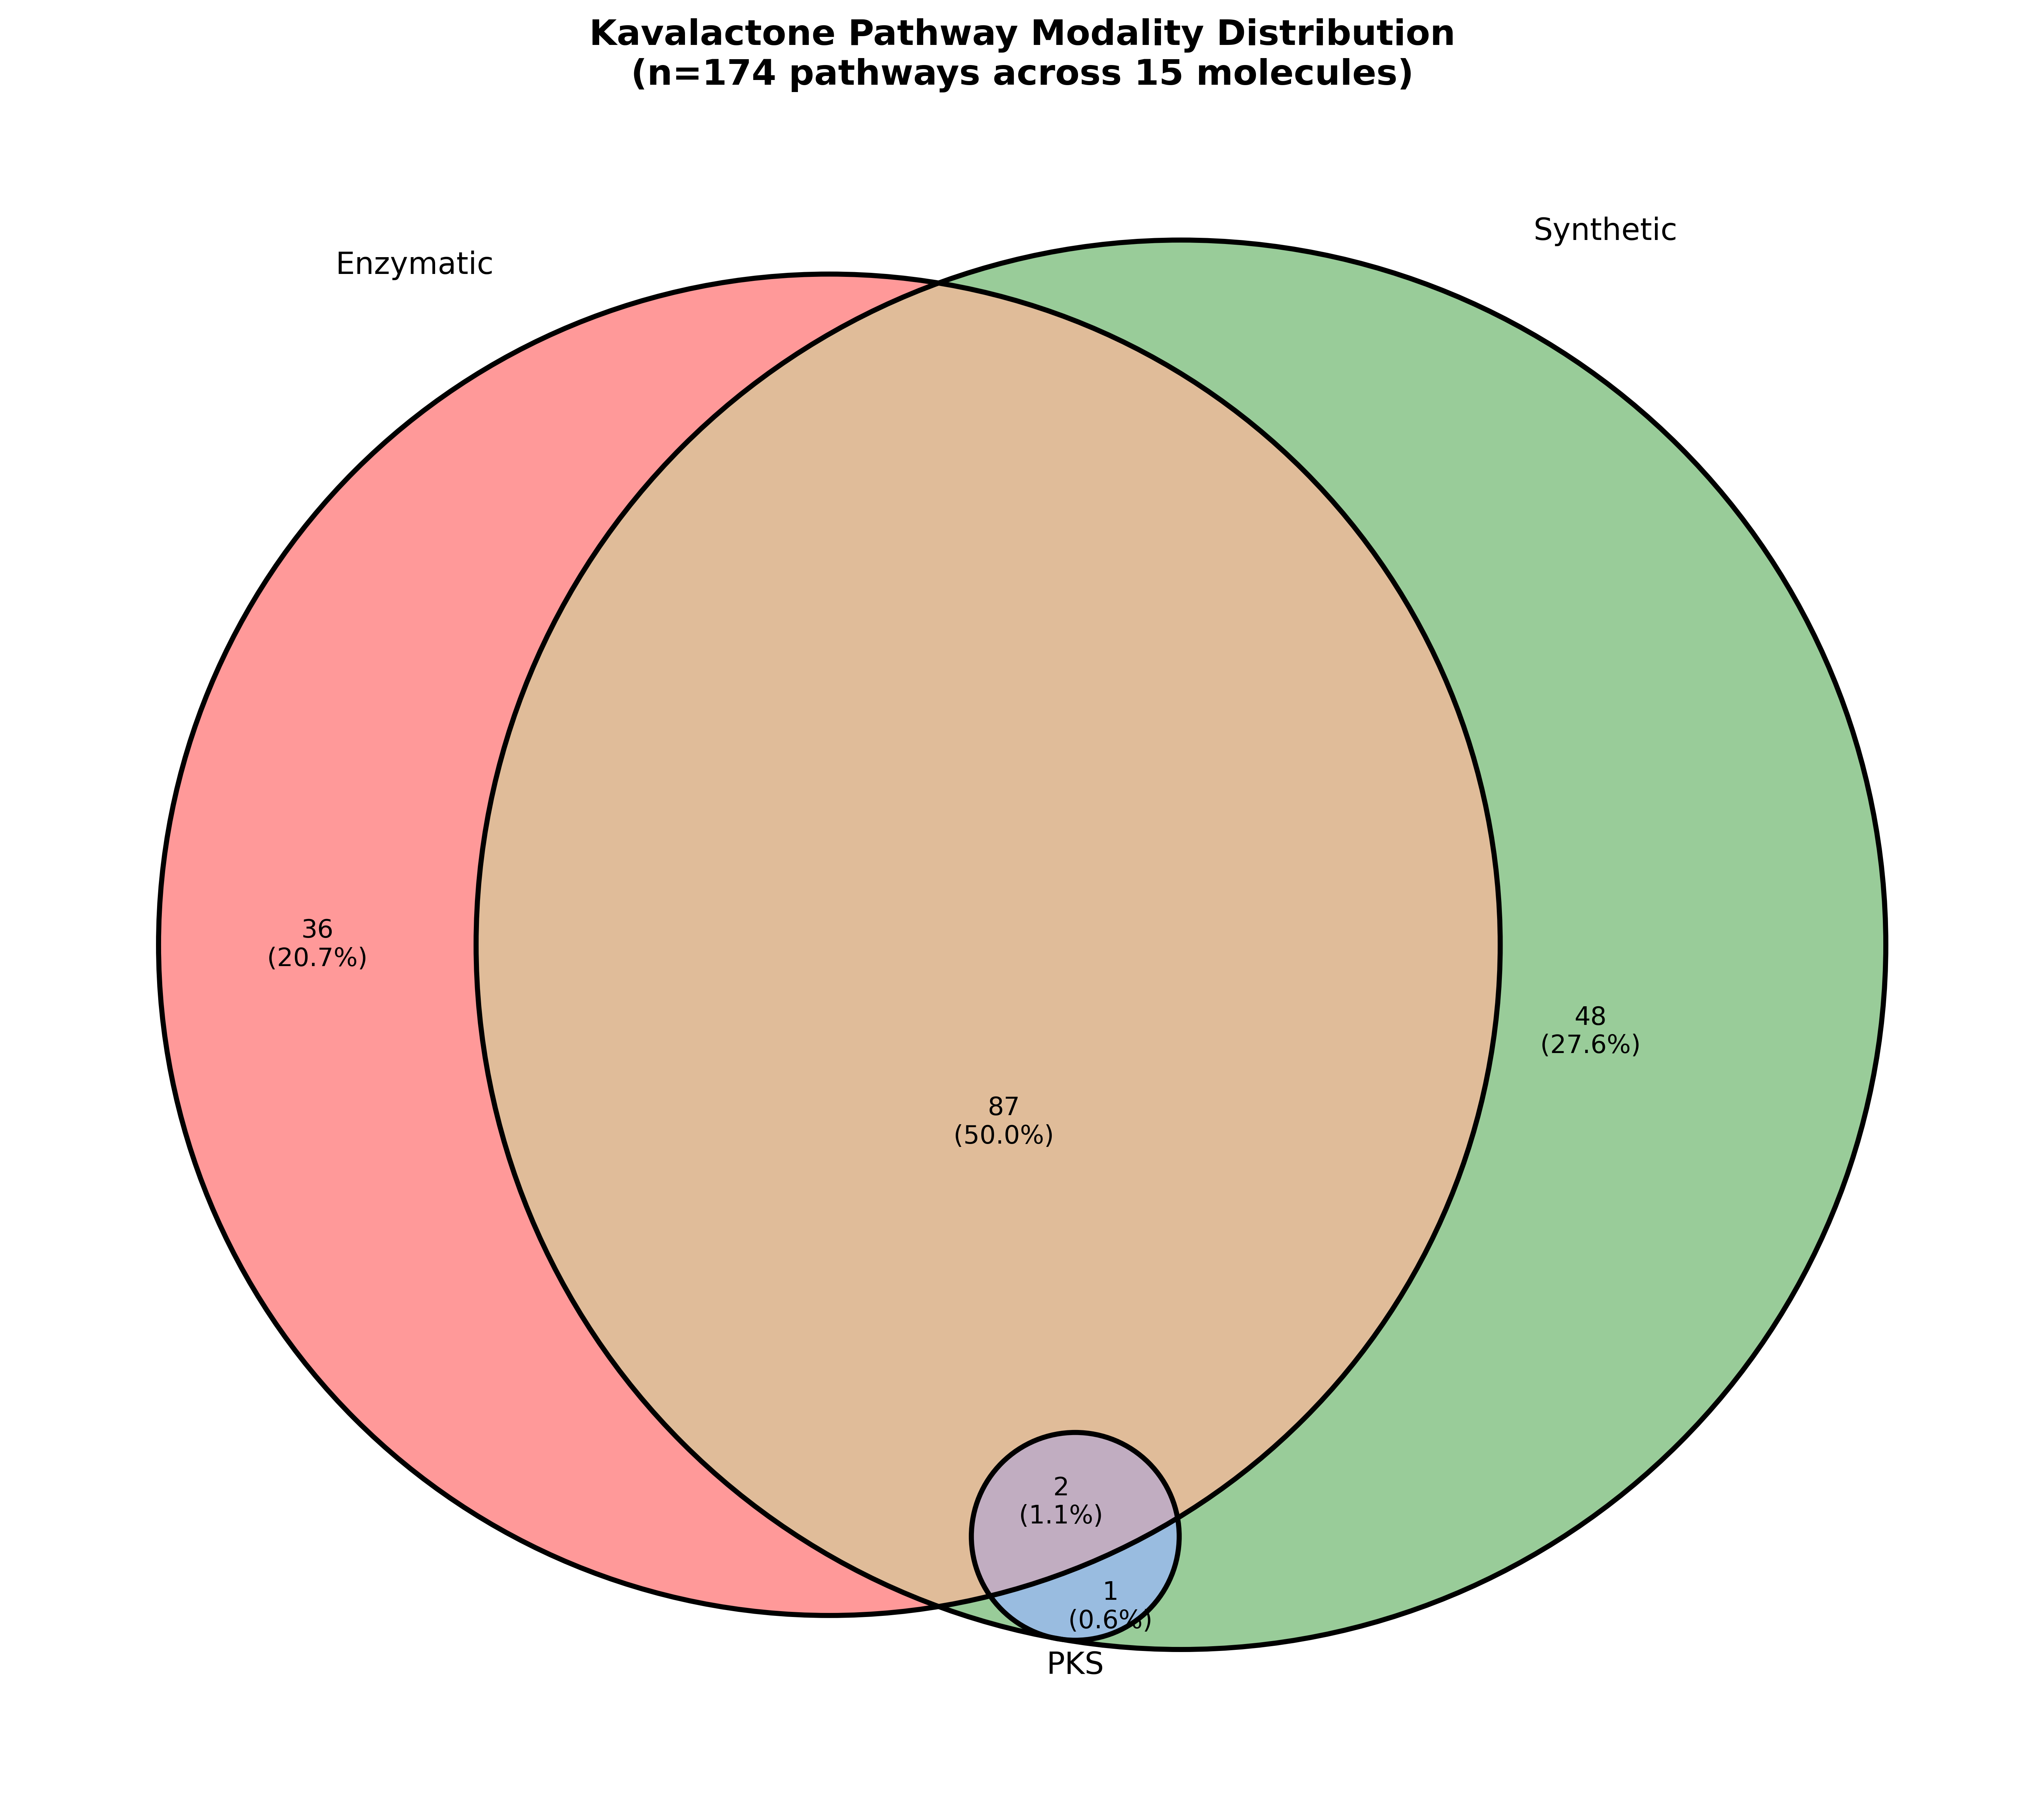

In [74]:
# Create Venn diagram
fig, ax = plt.subplots(figsize=(12, 10))

# venn3 takes subsets in order: (100, 010, 110, 001, 101, 011, 111)
subsets = (enzymatic_only, synthetic_only, enzymatic_synthetic, 
           pks_only, enzymatic_pks, synthetic_pks, all_three)

v = venn3(subsets=subsets, 
          set_labels=('Enzymatic', 'Synthetic', 'PKS'),
          ax=ax)

# Style the diagram with percentages
total_pathways = len(non_target_df)
if v.get_label_by_id('100'):
    v.get_label_by_id('100').set_text(f'{enzymatic_only:,}\n({100*enzymatic_only/total_pathways:.1f}%)')
if v.get_label_by_id('010'):
    v.get_label_by_id('010').set_text(f'{synthetic_only:,}\n({100*synthetic_only/total_pathways:.1f}%)')
if v.get_label_by_id('110'):
    v.get_label_by_id('110').set_text(f'{enzymatic_synthetic:,}\n({100*enzymatic_synthetic/total_pathways:.1f}%)')
if v.get_label_by_id('001') and pks_only > 0:
    v.get_label_by_id('001').set_text(f'{pks_only:,}\n({100*pks_only/total_pathways:.1f}%)')
if v.get_label_by_id('101') and enzymatic_pks > 0:
    v.get_label_by_id('101').set_text(f'{enzymatic_pks:,}\n({100*enzymatic_pks/total_pathways:.1f}%)')
if v.get_label_by_id('011') and synthetic_pks > 0:
    v.get_label_by_id('011').set_text(f'{synthetic_pks:,}\n({100*synthetic_pks/total_pathways:.1f}%)')
if v.get_label_by_id('111') and all_three > 0:
    v.get_label_by_id('111').set_text(f'{all_three:,}\n({100*all_three/total_pathways:.1f}%)')

plt.title(f'{ANALYSIS_NAME} Pathway Modality Distribution\n(n={total_pathways:,} pathways across {len(df)} molecules)', 
          fontsize=14, fontweight='bold')
venn3_circles(subsets=subsets, ax=ax)

plt.tight_layout()
venn_path = RESULTS_DIR / 'pathway_modality_venn_diagram.png'
plt.savefig(venn_path, dpi=300, bbox_inches='tight')
print(f"Venn diagram saved to: {venn_path}")
plt.show()

Charts saved to: ../results/kavalactone_pathways/pathway_modality_charts.png


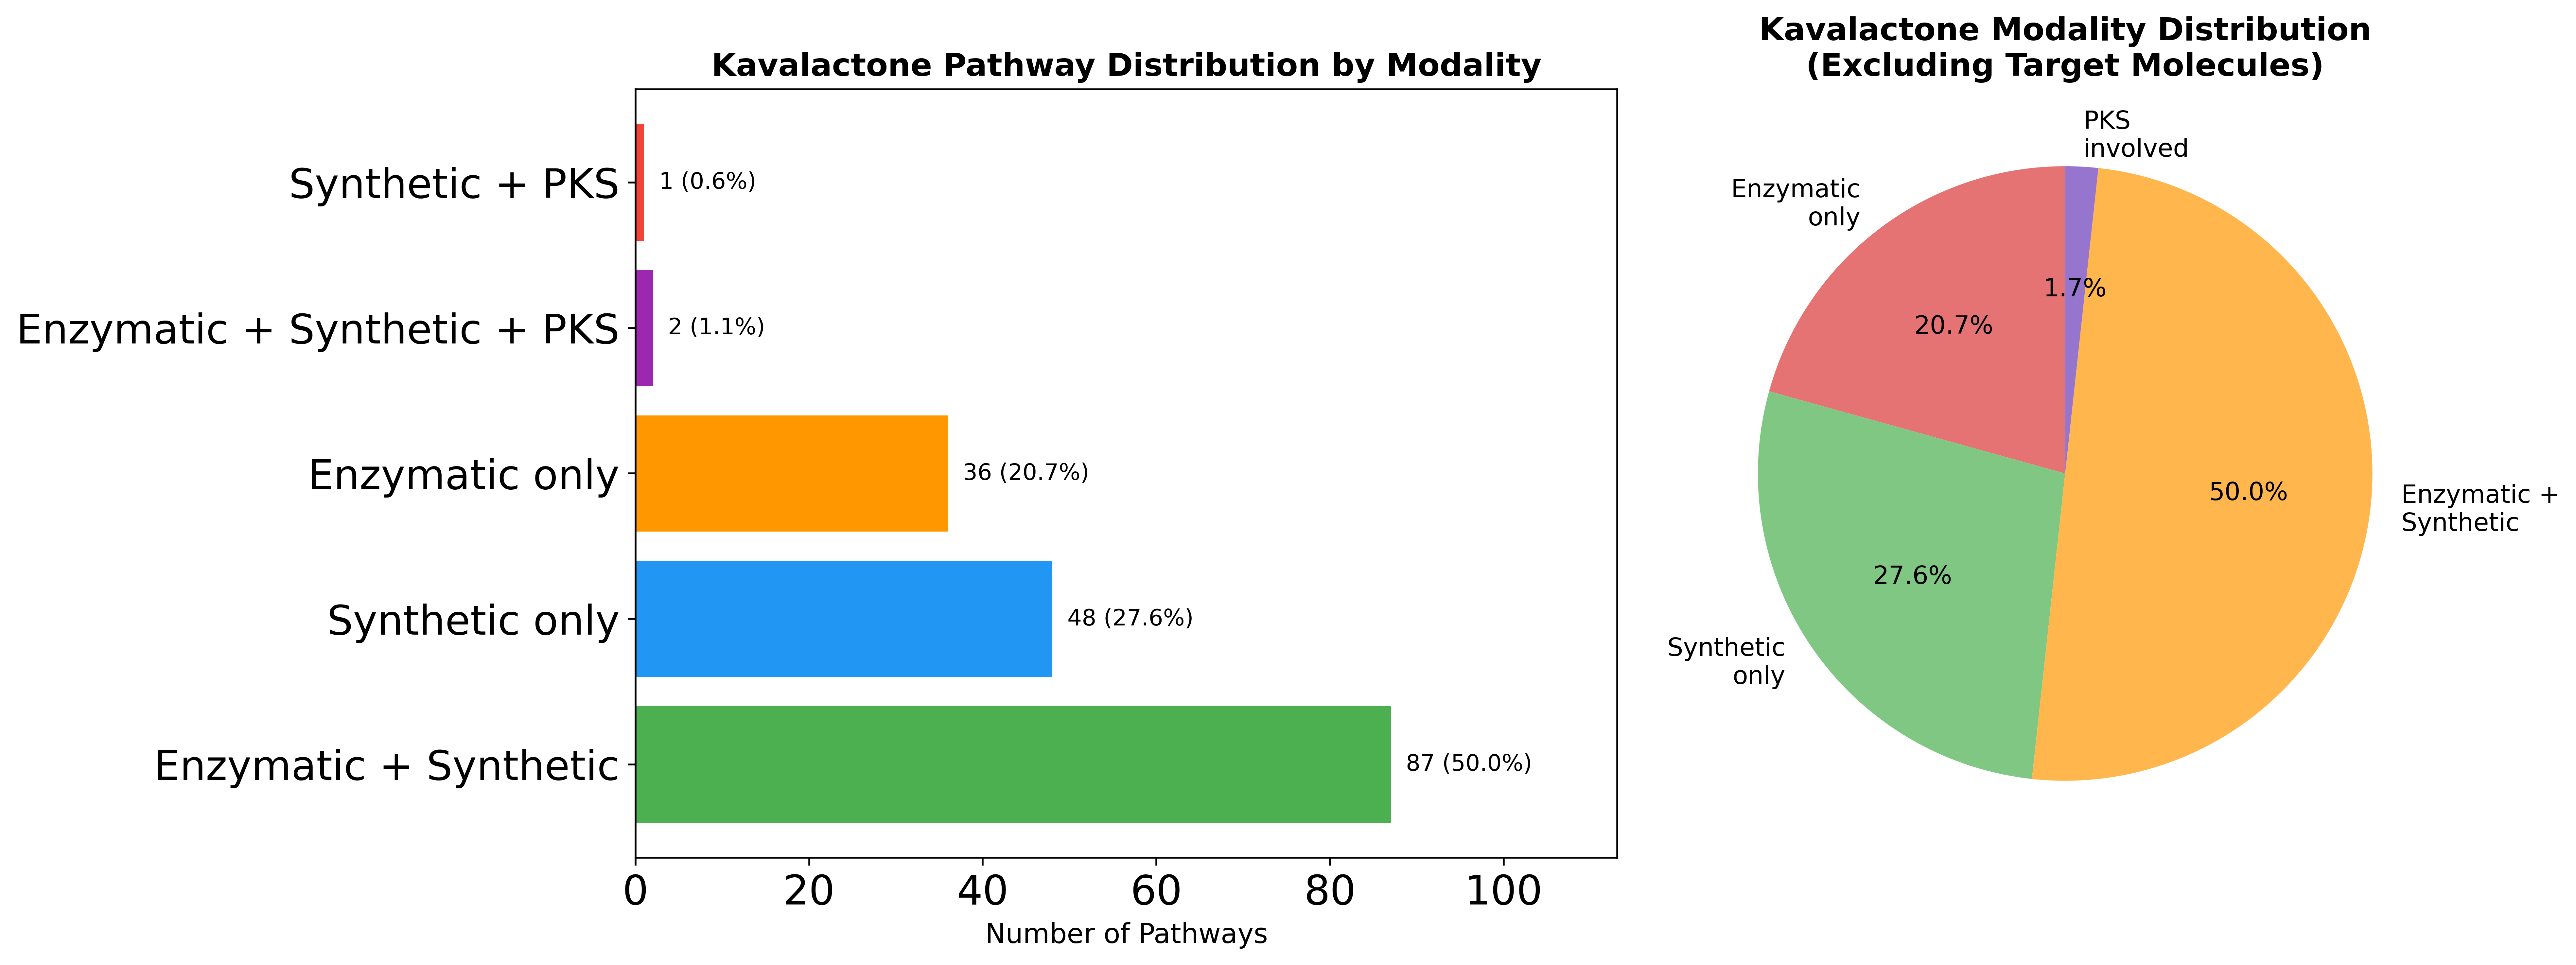


MODALITY SUMMARY STATISTICS

Total pathways (excluding target molecules): 174

Pathways involving enzymatic reactions: 125 (71.8%)
Pathways involving synthetic chemistry: 138 (79.3%)
Pathways involving PKS: 3 (1.7%)


In [75]:
# Create bar and pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of modality categories
ax1 = axes[0]
categories = category_counts.index.tolist()
counts = category_counts.values.tolist()
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#F44336', '#00BCD4', '#795548', '#607D8B']

bars = ax1.barh(categories, counts, color=colors[:len(categories)])
ax1.set_xlabel('Number of Pathways', fontsize=12)
ax1.set_title(f'{ANALYSIS_NAME} Pathway Distribution by Modality', fontsize=14, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, counts):
    pct = 100 * count / sum(counts)
    ax1.text(bar.get_width() + max(counts)*0.02, bar.get_y() + bar.get_height()/2, 
             f'{count:,} ({pct:.1f}%)', va='center', fontsize=10)

ax1.set_xlim(0, max(counts) * 1.3)

# Pie chart showing simplified breakdown
ax2 = axes[1]
pie_data = [enzymatic_only, synthetic_only, enzymatic_synthetic]
pie_labels = ['Enzymatic\nonly', 'Synthetic\nonly', 'Enzymatic +\nSynthetic']
pie_colors = ['#E57373', '#81C784', '#FFB74D']

# Add PKS if present
pks_total = pks_only + enzymatic_pks + synthetic_pks + all_three
if pks_total > 0:
    pie_data.append(pks_total)
    pie_labels.append('PKS\ninvolved')
    pie_colors.append('#9575CD')

wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                    colors=pie_colors, startangle=90, 
                                    textprops={'fontsize': 11})
ax2.set_title(f'{ANALYSIS_NAME} Modality Distribution\n(Excluding Target Molecules)', 
              fontsize=14, fontweight='bold')

plt.tight_layout()
charts_path = RESULTS_DIR / 'pathway_modality_charts.png'
plt.savefig(charts_path, dpi=300, bbox_inches='tight')
print(f"Charts saved to: {charts_path}")
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("MODALITY SUMMARY STATISTICS")
print("="*70)
total_non_target = len(non_target_df)
print(f"\nTotal pathways (excluding target molecules): {total_non_target:,}")
print(f"\nPathways involving enzymatic reactions: {enzymatic_only + enzymatic_synthetic + enzymatic_pks + all_three:,} ({100*(enzymatic_only + enzymatic_synthetic + enzymatic_pks + all_three)/total_non_target:.1f}%)")
print(f"Pathways involving synthetic chemistry: {synthetic_only + enzymatic_synthetic + synthetic_pks + all_three:,} ({100*(synthetic_only + enzymatic_synthetic + synthetic_pks + all_three)/total_non_target:.1f}%)")
print(f"Pathways involving PKS: {pks_only + enzymatic_pks + synthetic_pks + all_three:,} ({100*(pks_only + enzymatic_pks + synthetic_pks + all_three)/total_non_target:.1f}%)")

## 4. Per-Molecule Modality Analysis

In [76]:
# Per-molecule analysis: what modalities does each molecule have access to?
molecule_modalities = pathways_df.groupby('molecule').agg({
    'has_enzymatic': 'any',
    'has_synthetic': 'any', 
    'has_pks': 'any',
    'pathway_num': 'count'
}).rename(columns={'pathway_num': 'total_pathways'})

# Count molecules by their available modalities
molecules_with_enz_only = len(molecule_modalities[(molecule_modalities['has_enzymatic']) & 
                                                    (~molecule_modalities['has_synthetic']) & 
                                                    (~molecule_modalities['has_pks'])])

molecules_with_syn_only = len(molecule_modalities[(~molecule_modalities['has_enzymatic']) & 
                                                    (molecule_modalities['has_synthetic']) & 
                                                    (~molecule_modalities['has_pks'])])

molecules_with_pks = len(molecule_modalities[molecule_modalities['has_pks']])
molecules_with_both = len(molecule_modalities[(molecule_modalities['has_enzymatic']) & 
                                               (molecule_modalities['has_synthetic'])])

print("="*70)
print("PER-MOLECULE MODALITY ACCESS")
print("="*70)
print(f"\nTotal molecules analyzed: {len(molecule_modalities)}")
print(f"\nMolecules with at least one enzymatic pathway: {molecule_modalities['has_enzymatic'].sum()}")
print(f"Molecules with at least one synthetic pathway: {molecule_modalities['has_synthetic'].sum()}")
print(f"Molecules with at least one PKS pathway: {molecule_modalities['has_pks'].sum()}")

print(f"\n--- Exclusive Access ---")
print(f"Molecules with ONLY enzymatic pathways: {molecules_with_enz_only}")
print(f"Molecules with ONLY synthetic pathways: {molecules_with_syn_only}")
print(f"Molecules accessible via BOTH enzymatic AND synthetic: {molecules_with_both}")

# List molecules with exclusive access
if molecules_with_syn_only > 0:
    syn_only_molecules = molecule_modalities[(~molecule_modalities['has_enzymatic']) & 
                                              (molecule_modalities['has_synthetic']) & 
                                              (~molecule_modalities['has_pks'])].index.tolist()
    print(f"\nMolecules accessible ONLY via synthetic chemistry ({len(syn_only_molecules)}):")
    for mol in syn_only_molecules:
        count = molecule_modalities.loc[mol, 'total_pathways']
        print(f"  - {mol} ({count} pathways)")

if molecules_with_enz_only > 0:
    enz_only_molecules = molecule_modalities[(molecule_modalities['has_enzymatic']) & 
                                              (~molecule_modalities['has_synthetic']) & 
                                              (~molecule_modalities['has_pks'])].index.tolist()
    print(f"\nMolecules accessible ONLY via enzymatic reactions ({len(enz_only_molecules)}):")
    for mol in enz_only_molecules:
        count = molecule_modalities.loc[mol, 'total_pathways']
        print(f"  - {mol} ({count} pathways)")

PER-MOLECULE MODALITY ACCESS

Total molecules analyzed: 14

Molecules with at least one enzymatic pathway: 13
Molecules with at least one synthetic pathway: 11
Molecules with at least one PKS pathway: 2

--- Exclusive Access ---
Molecules with ONLY enzymatic pathways: 3
Molecules with ONLY synthetic pathways: 1
Molecules accessible via BOTH enzymatic AND synthetic: 10

Molecules accessible ONLY via synthetic chemistry (1):
  - methysticin (4 pathways)

Molecules accessible ONLY via enzymatic reactions (3):
  - 11_methoxy_12_hydroxydehydrokavain (2 pathways)
  - 5_6_7_8_tetrahydroyangonin (2 pathways)
  - 5_6_dihydroyangonin (2 pathways)


In [77]:
# Per-molecule detailed modality access
print("\n--- Detailed Modality Access per Molecule ---")
for mol, row in molecule_modalities.iterrows():
    modalities = []
    if row['has_enzymatic']:
        modalities.append('Enz')
    if row['has_synthetic']:
        modalities.append('Syn')
    if row['has_pks']:
        modalities.append('PKS')
    mod_str = '+'.join(modalities) if modalities else 'None'
    print(f"  {mol}: {row['total_pathways']} pathways [{mod_str}]")


--- Detailed Modality Access per Molecule ---
  10_methoxyyangonin: 3 pathways [Enz+Syn]
  11_methoxy_12_hydroxydehydrokavain: 2 pathways [Enz]
  11_methoxyyangonin: 6 pathways [Enz+Syn]
  5_6_7_8_tetrahydroyangonin: 2 pathways [Enz]
  5_6_dehydromethysticin: 4 pathways [Enz+Syn]
  5_6_dihydroyangonin: 2 pathways [Enz]
  5_hydroxykavain: 1 pathways [Enz+Syn+PKS]
  7_8_dihydrokavain: 6 pathways [Enz+Syn+PKS]
  7_8_dihydromethysticin: 1 pathways [Enz+Syn]
  7_8_dihydroyangonin: 18 pathways [Enz+Syn]
  Yangonin: 31 pathways [Enz+Syn]
  desmethoxyyangonin: 68 pathways [Enz+Syn]
  kavain: 26 pathways [Enz+Syn]
  methysticin: 4 pathways [Syn]


## 5. Final Summary Table and Export

In [78]:
# Create comprehensive summary DataFrame
pks_involved = pks_only + enzymatic_pks + synthetic_pks + all_three

summary_data = {
    'Metric': [
        'Total molecules analyzed',
        'Molecules with ≥1 successful pathway',
        'Molecules with no pathway',
        'Total pathways across all molecules',
        '---',
        'Pathways: Enzymatic only',
        'Pathways: Synthetic only',
        'Pathways: Enzymatic + Synthetic',
        'Pathways: PKS only',
        'Pathways: Enzymatic + PKS',
        'Pathways: Synthetic + PKS',
        'Pathways: Enzymatic + Synthetic + PKS',
        'Pathways: PKS involved (total)',
        'Pathways: Target (no transformation)',
        '---',
        'Molecules with enzymatic access',
        'Molecules with synthetic access',
        'Molecules with PKS access',
        'Molecules with ONLY enzymatic',
        'Molecules with ONLY synthetic',
    ],
    'Value': [
        len(df),
        int(molecules_with_pathways),
        int(molecules_without_pathways),
        int(df['pathway_count'].sum()),
        '---',
        enzymatic_only,
        synthetic_only,
        enzymatic_synthetic,
        pks_only,
        enzymatic_pks,
        synthetic_pks,
        all_three,
        pks_involved,
        len(pathways_df[pathways_df['is_target']]),
        '---',
        int(molecule_modalities['has_enzymatic'].sum()),
        int(molecule_modalities['has_synthetic'].sum()),
        int(molecule_modalities['has_pks'].sum()),
        molecules_with_enz_only,
        molecules_with_syn_only,
    ],
    'Percentage': [
        '100%',
        f"{100*molecules_with_pathways/len(df):.1f}%",
        f"{100*molecules_without_pathways/len(df):.1f}%",
        '100%',
        '---',
        f"{100*enzymatic_only/len(pathways_df):.1f}%",
        f"{100*synthetic_only/len(pathways_df):.1f}%",
        f"{100*enzymatic_synthetic/len(pathways_df):.1f}%",
        f"{100*pks_only/len(pathways_df):.2f}%",
        f"{100*enzymatic_pks/len(pathways_df):.2f}%",
        f"{100*synthetic_pks/len(pathways_df):.2f}%",
        f"{100*all_three/len(pathways_df):.2f}%",
        f"{100*pks_involved/len(pathways_df):.2f}%",
        f"{100*len(pathways_df[pathways_df['is_target']])/len(pathways_df):.2f}%",
        '---',
        f"{100*molecule_modalities['has_enzymatic'].sum()/len(molecule_modalities):.1f}%",
        f"{100*molecule_modalities['has_synthetic'].sum()/len(molecule_modalities):.1f}%",
        f"{100*molecule_modalities['has_pks'].sum()/len(molecule_modalities):.1f}%",
        f"{100*molecules_with_enz_only/len(molecule_modalities):.1f}%",
        f"{100*molecules_with_syn_only/len(molecule_modalities):.1f}%",
    ]
}

summary_df = pd.DataFrame(summary_data)

# Save all outputs with 00_ prefix for summary to appear at top
# 1. Final summary table (with 00_ prefix)
summary_path = RESULTS_DIR / f"00_pathway_analysis_summary.csv"
summary_df.to_csv(summary_path, index=False)

# 2. Detailed pathway data
pathways_csv_path = RESULTS_DIR / "all_pathways_with_modalities.csv"
pathways_df.to_csv(pathways_csv_path, index=False)

# 3. Per-molecule summary
molecule_summary_path = RESULTS_DIR / "molecule_modality_summary.csv"
molecule_modalities.to_csv(molecule_summary_path)

# 4. Basic results (pathway counts per molecule)
results_path = RESULTS_DIR / "pathway_counts_per_molecule.csv"
df.to_csv(results_path, index=False)

print("="*70)
print("FILES SAVED")
print("="*70)
print(f"\n1. Summary table: {summary_path}")
print(f"2. All pathways with modalities: {pathways_csv_path}")
print(f"3. Per-molecule modality summary: {molecule_summary_path}")
print(f"4. Pathway counts per molecule: {results_path}")
print(f"5. Venn diagram: {RESULTS_DIR / 'pathway_modality_venn_diagram.png'}")
print(f"6. Charts: {RESULTS_DIR / 'pathway_modality_charts.png'}")

FILES SAVED

1. Summary table: ../results/kavalactone_pathways/00_pathway_analysis_summary.csv
2. All pathways with modalities: ../results/kavalactone_pathways/all_pathways_with_modalities.csv
3. Per-molecule modality summary: ../results/kavalactone_pathways/molecule_modality_summary.csv
4. Pathway counts per molecule: ../results/kavalactone_pathways/pathway_counts_per_molecule.csv
5. Venn diagram: ../results/kavalactone_pathways/pathway_modality_venn_diagram.png
6. Charts: ../results/kavalactone_pathways/pathway_modality_charts.png


In [79]:
# Display final summary table
print("\n" + "="*70)
print(f"FINAL SUMMARY TABLE: {ANALYSIS_NAME.upper()}")
print("="*70 + "\n")
display(summary_df)


FINAL SUMMARY TABLE: KAVALACTONE



,Metric,Value,Percentage
0,Total molecules analyzed,15,100%
1,Molecules with ≥1 successful pathway,15,100.0%
2,Molecules with no pathway,0,0.0%
3,Total pathways across all molecules,174,100%
4,---,---,---
5,Pathways: Enzymatic only,36,20.7%
6,Pathways: Synthetic only,48,27.6%
7,Pathways: Enzymatic + Synthetic,87,50.0%
8,Pathways: PKS only,0,0.00%
9,Pathways: Enzymatic + PKS,0,0.00%


In [80]:
# Display molecules sorted by pathway count
print("\n" + "="*70)
print(f"ALL MOLECULES SORTED BY PATHWAY COUNT")
print("="*70 + "\n")

sorted_df = df[['molecule', 'pathway_count', 'has_successful_pathway']].sort_values(
    'pathway_count', ascending=False
).reset_index(drop=True)
sorted_df.index = sorted_df.index + 1  # 1-indexed
display(sorted_df)


ALL MOLECULES SORTED BY PATHWAY COUNT



,molecule,pathway_count,has_successful_pathway
1,desmethoxyyangonin,68,True
2,Yangonin,31,True
3,kavain,26,True
4,7_8_dihydroyangonin,18,True
5,11_methoxyyangonin,6,True
6,7_8_dihydrokavain,6,True
7,5_6_dehydromethysticin,4,True
8,10_methoxyyangonin,3,True
9,11_methoxy_12_hydroxydehydrokavain,2,True
10,5_6_7_8_tetrahydroyangonin,2,True


UpSet plot saved to: ../results/kavalactone_pathways/pathway_modality_upset_plot.png


/Users/yashchainani/miniforge3/envs/MCTS_py311_env/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/yashchainani/miniforge3/envs/MCTS_py311_env/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

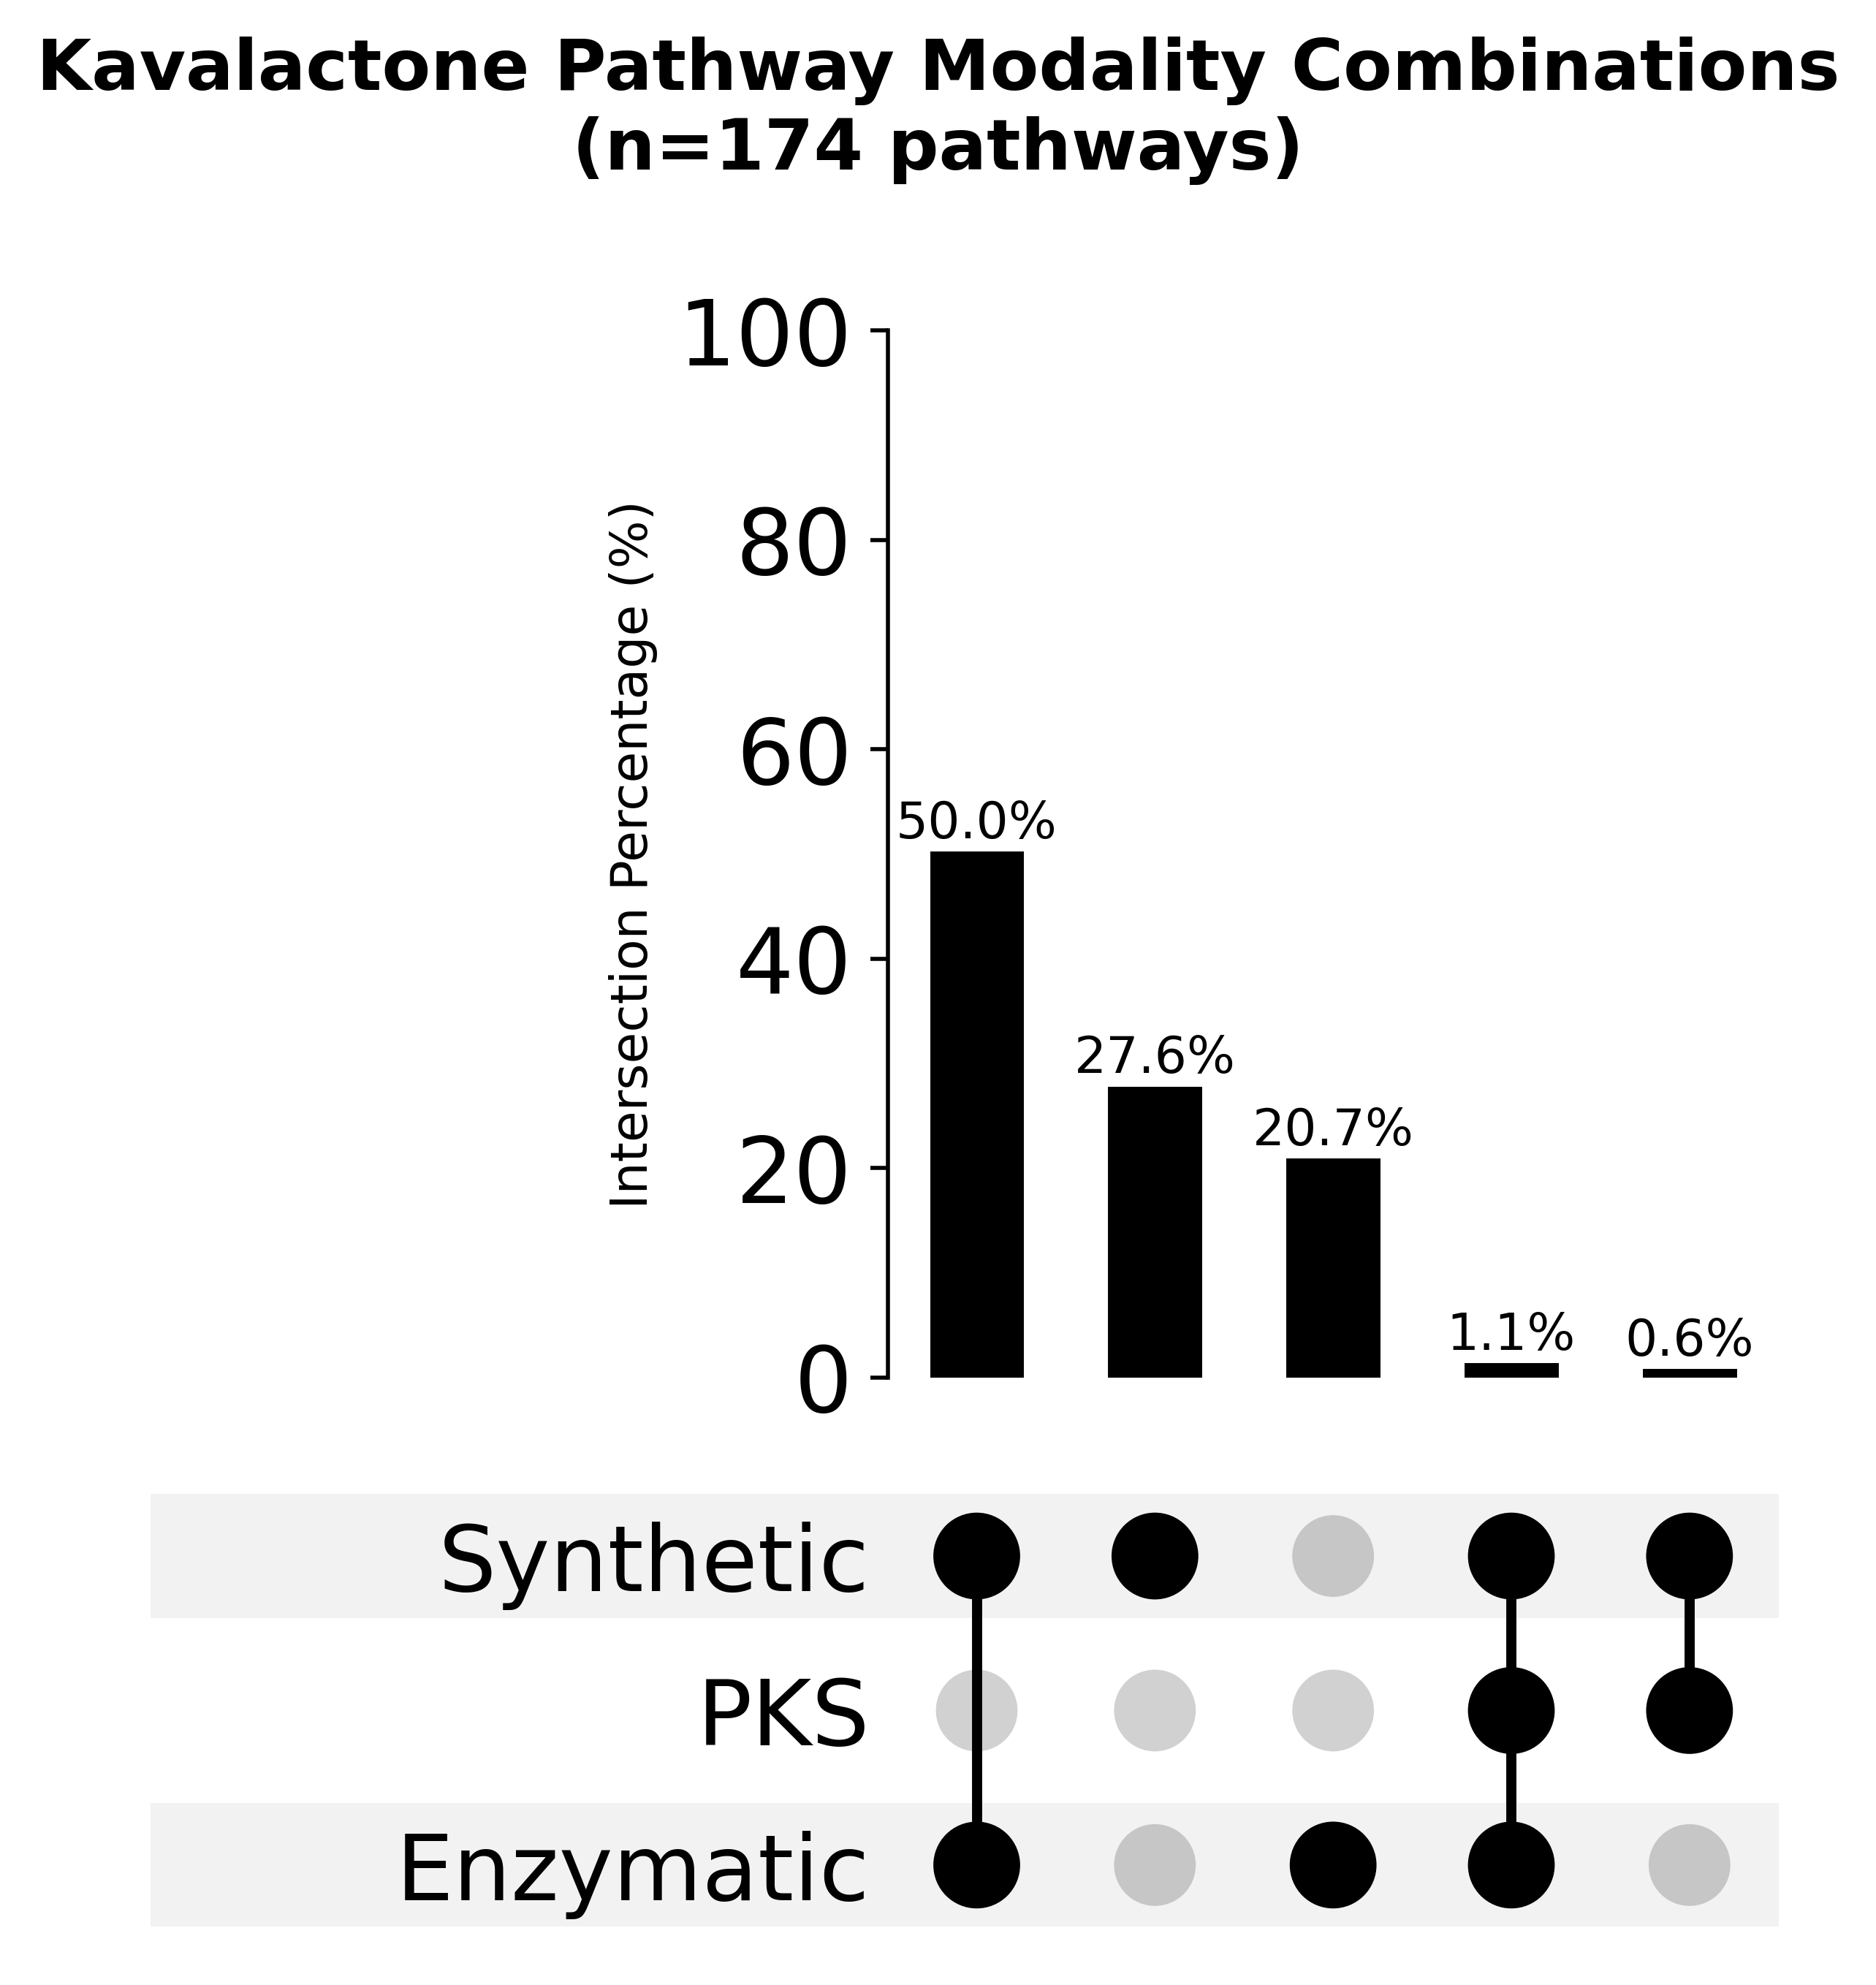


MODALITY COMBINATION PERCENTAGES (UpSet Plot Data)
  Enzymatic + Synthetic                   :     87 (50.00%)
  Synthetic                               :     48 (27.59%)
  Enzymatic                               :     36 (20.69%)
  Enzymatic + PKS + Synthetic             :      2 ( 1.15%)
  PKS + Synthetic                         :      1 ( 0.57%)


In [81]:
# Create UpSet plot for pathway modality combinations
# Install upsetplot if not available
try:
    from upsetplot import UpSet, from_memberships
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'upsetplot'])
    from upsetplot import UpSet, from_memberships

import numpy as np
from collections import Counter

# Filter out target molecules for modality analysis
upset_df = pathways_df[~pathways_df['is_target']].copy()
total_pathways_for_upset = len(upset_df)

# Create membership lists for each pathway
memberships = []
for _, row in upset_df.iterrows():
    membership = []
    if row['has_enzymatic']:
        membership.append('Enzymatic')
    if row['has_synthetic']:
        membership.append('Synthetic')
    if row['has_pks']:
        membership.append('PKS')
    if membership:  # Only add if at least one modality
        memberships.append(tuple(sorted(membership)))  # Sort for consistent keys

# Count each combination and convert to percentages
combination_counts = Counter(memberships)
combination_percentages = {combo: (count / total_pathways_for_upset) * 100 
                           for combo, count in combination_counts.items()}

# Create data for upsetplot with percentage values
memberships_for_plot = list(combination_percentages.keys())
pct_values = list(combination_percentages.values())

# Create Series with percentage values
upset_pct_data = from_memberships(memberships_for_plot, data=pct_values)

# Ensure all three categories (Enzymatic, Synthetic, PKS) are present in the index
# This ensures consistent visualization across datasets even when PKS is not used
required_categories = ['Enzymatic', 'PKS', 'Synthetic']
current_categories = list(upset_pct_data.index.names)

# Check if PKS is missing and add it if needed
missing_categories = [cat for cat in required_categories if cat not in current_categories]
if missing_categories:
    # Rebuild the data with all categories by adding a dummy entry with 0 value
    # that includes all categories, then we'll filter it out from display
    import pandas as pd
    
    # Get current index as a dataframe
    idx_df = upset_pct_data.index.to_frame(index=False)
    
    # Add missing category columns with False values
    for cat in missing_categories:
        idx_df[cat] = False
    
    # Reorder columns to have consistent order
    idx_df = idx_df[required_categories]
    
    # Create new MultiIndex
    new_index = pd.MultiIndex.from_frame(idx_df)
    
    # Create new Series with the proper index
    upset_pct_data = pd.Series(upset_pct_data.values, index=new_index)

# Create the UpSet plot with percentages
fig = plt.figure(figsize=(12, 8))
upset = UpSet(
    upset_pct_data,
    subset_size='sum',  # Sum the percentage values
    show_counts='{:.1f}%',  # Format as percentage with 1 decimal place
    show_percentages=False,
    sort_by='cardinality',
    sort_categories_by=None,  # Keep categories in consistent order
    facecolor='black',
    element_size=46,
    totals_plot_elements=0  # Remove the horizontal bars showing totals per category
)

# Plot
axes_dict = upset.plot(fig=fig)

# Format the y-axis and remove grid lines
intersections_ax = axes_dict['intersections']
intersections_ax.set_ylabel('Intersection Percentage (%)')
intersections_ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100
intersections_ax.grid(False)  # Explicitly remove grid lines

# Remove grid lines from all axes in the plot
for ax_name, ax in axes_dict.items():
    if ax is not None:
        ax.grid(False)

# Update the title
plt.suptitle(f'{ANALYSIS_NAME} Pathway Modality Combinations\n(n={total_pathways_for_upset:,} pathways)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
upset_path = RESULTS_DIR / 'pathway_modality_upset_plot.png'
plt.savefig(upset_path, dpi=300, bbox_inches='tight')
print(f"UpSet plot saved to: {upset_path}")
plt.show()

# Print the percentage breakdown
print("\n" + "="*70)
print("MODALITY COMBINATION PERCENTAGES (UpSet Plot Data)")
print("="*70)

for combo, count in sorted(combination_counts.items(), key=lambda x: -x[1]):
    combo_str = " + ".join(combo)
    pct = 100 * count / total_pathways_for_upset
    print(f"  {combo_str:40s}: {count:6,} ({pct:5.2f}%)")